# Лабороторная работа №3

С попощью команды ***lscpu*** и изучив содержание каталога **/sys/devices/system/cpu/cpu0/cache/index{1,2,3}** выведем на экран параметры CPU:
```
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                6
On-line CPU(s) list:   0-5
Thread(s) per core:    1
Core(s) per socket:    6
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 60
Stepping:              3
CPU MHz:               3192.614
BogoMIPS:              6385.22
Hypervisor vendor:     KVM
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              6144K
NUMA node0 CPU(s):     0-5

L1 cache size: 32K
L1 ways count: 8
L1 line size: 64
L1 type: per-cpu
L2 cache size: 256K
L2 ways count: 8
L2 line size: 64
L2 type: per-cpu
L3 cache size: 6144K
L3 ways count: 12
L3 line size: 64
L3 type: shared

```

Кэш L1 делится на 32Кб кэша инструкций и 32Кб кэша данных. Нам в первую очередь интересен кэш с данными. Следовательно, имеем следующую конфигурацию:

- **6 CPU**
- **CacheLine = 2^6 (64b)**
- **L1 = 32Kb, 8-way, per-cpu**
- **L2 = 256 Kb, 8-way, per-cpu**
- **L3 = 6Mb, 8-way, per-cpu**
- **Number of blocks: 32Kb / 64b = 512**
- **Number of sets: 512 / 8 = 64**


Учел замечания по поводу некорректности результатов запуска на виртуальной машине и запустил все три алгоритма на хост машине с необходимыми размерами матриц (1023, 1024, 1025, 1040, 1041, 1050, 1100). Распарсим лог и выведем результат в виде графиков:

In [4]:
def read_log_file (path):
    '''
    :return
        * results = {Simple: [(1000, 0.8932), ... ,], Block: [(1000, 0.8932), ... ,], Swapped: [(1000, 0.8932), ... ,]}
    '''

    results = dict()
    for line in open(path):
        if 'n = ' in line:
            n = int(line.split("=")[1])
        elif 'time' in line:
            method = line.split(":")[0][4:]
            value = float(line.split(":")[1])
            results[method] = results.get(method, list())
            pair = (n, value)
            results[method].append(pair)
    return results

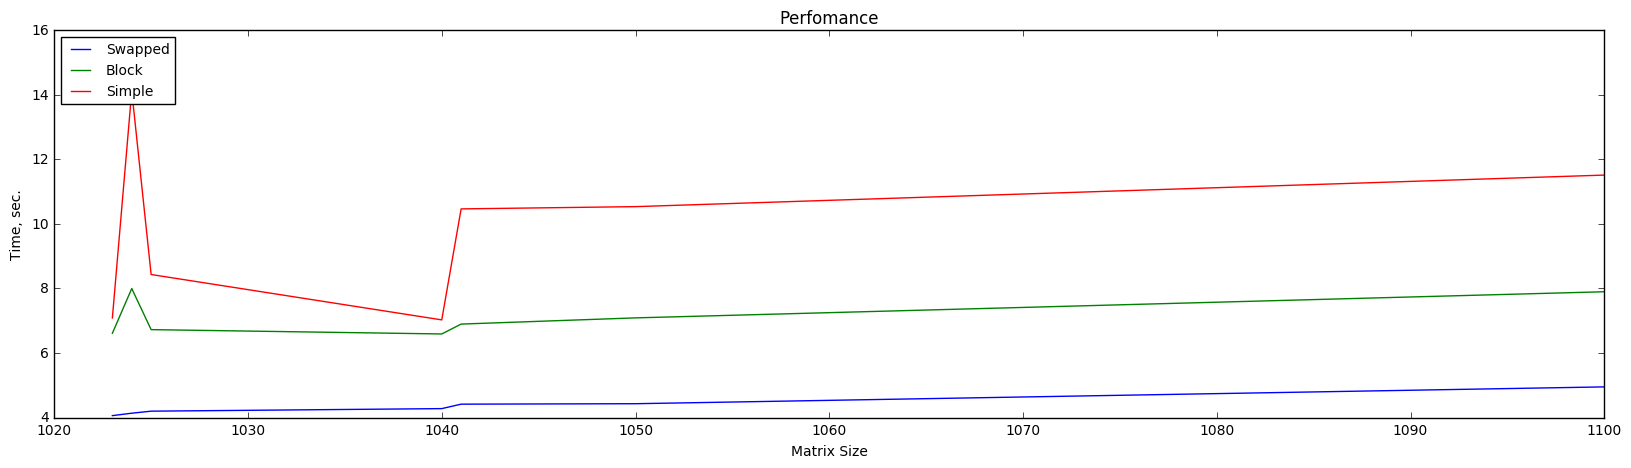

In [6]:
import matplotlib.pyplot as plt

def plot_results(results):
    methods = results.keys()

    for method in methods:
        plt.plot([row[0] for row in results[method]], [row[1] for row in results[method]], label=method)
        plt.legend(loc=2, fontsize=10)
        plt.xlabel('Matrix Size')
        plt.ylabel('Time, sec.')
        plt.title('Perfomance')
        fig_size = [20, 5]
        plt.rcParams["figure.figsize"] = fig_size
    plt.show()

results1 = read_log_file("C:\\Users\Daniil_Skokleenko\\Desktop\\Lab3\\Logs\\Runtime.log")


plot_results(results1)

При n=1024 и n=1041 очевидены "всплески", которые не наблюдались при запуске на виртуальной машине. Попробуем разобраться с помощью valgrind-а в причинах этих всплесков:

In [9]:
# matrix_sizes=( 1023 1024 1025 1040 1041 1050 1100 )
# for n in "${matrix_sizes[@]}"
# do
#    valgrind --tool=cachegrind ./Simple $n >> Logs/Simple.log 2>&1
# done

# for n in "${matrix_sizes[@]}"
# do
#    valgrind --tool=cachegrind ./Block $n >> Logs/Block.log 2>&1
#done

# for n in "${matrix_sizes[@]}"
# do
#    valgrind --tool=cachegrind ./Swapped $n >> Logs/Swapped.log 2>&1
#done

Логи результатов хранятся в папке Logs. Распарсим их и выведем результат в виде графиков:

In [34]:
def read_log_file (path):
    results = dict()
    for line in open(path):
        if 'n = ' in line:
            n = int(line.split("=")[1])
        elif 'D1  misses' in line:
            miss = "L1"
            value = int(line.split(':')[1].split('(')[0].replace(',', ''))
            results[miss] = results.get(miss, list())
            pair = (n, value)
            results[miss].append(pair)
        elif 'LLd misses' in line:
            miss = "L3"
            value = int(line.split(':')[1].split('(')[0].replace(',', ''))
            results[miss] = results.get(miss, list())
            pair = (n, value)
            results[miss].append(pair)
    return results

In [35]:
def plot_results(results):
    Misses = results.keys()
    i = 1;
    for Miss in Misses:
        plt.subplot(1,2,i)
        plt.plot([row[0] for row in results[Miss]], [row[1] for row in results[Miss]], 'g*-', label=Miss)
        plt.legend(loc=2, fontsize=10)
        plt.xlabel('Matrix Size')
        plt.ylabel('Cache Misses')
        plt.title('Valgrind')
        #fig_size = [20, 5]
        #plt.rcParams["figure.figsize"] = fig_size
        i += 1
    plt.show()

#### Простой алогритм

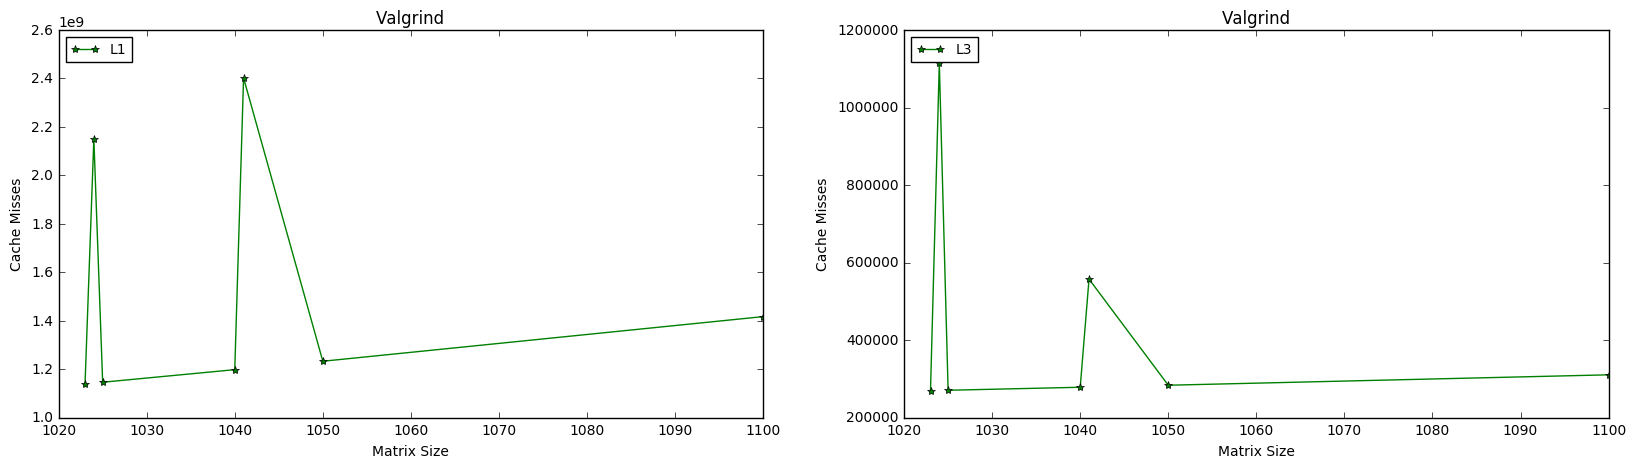

In [53]:
algorithm = "Simple"
results = read_log_file("Logs\\" + algorithm + ".log")
plot_results(results)

#### Блочный алгоритм

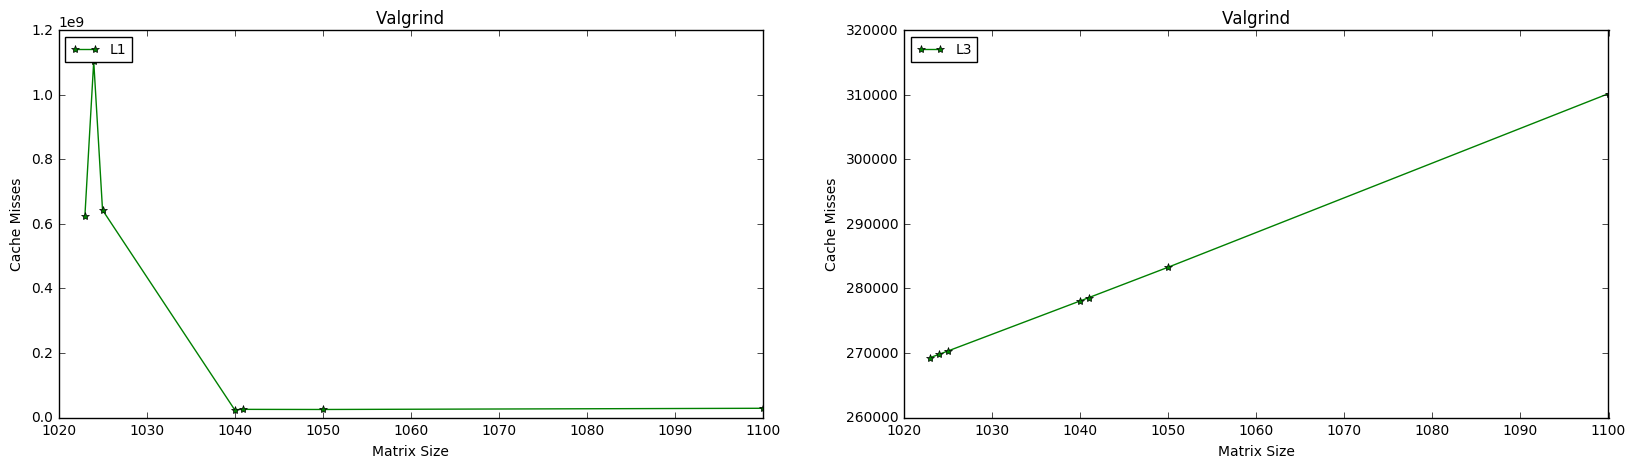

In [51]:
algorithm = "Block"
results = read_log_file("Logs\\" + algorithm + ".log")
plot_results(results)

#### Swapped алгоритм

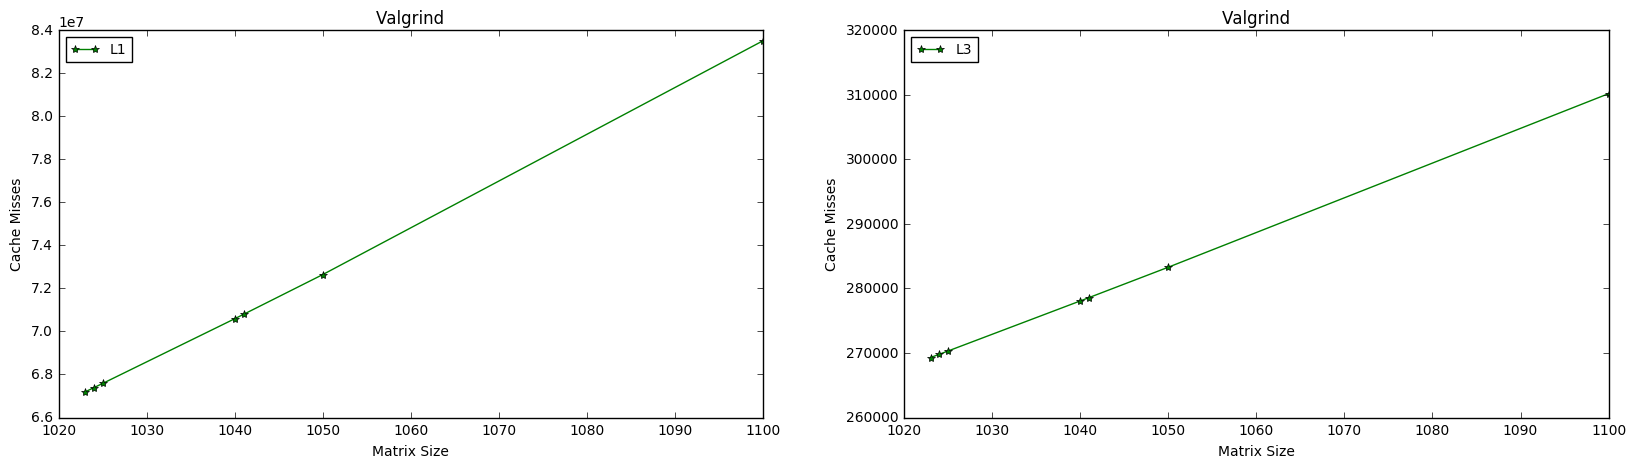

In [50]:
algorithm = "Swapped"
results = read_log_file("Logs\\" + algorithm + ".log")
plot_results(results)

### Анализ графиков

На графиках L1 и L3 для алгоритма Simple  отчетливо заметны скачки при n = 1024 и n = 1041. Это происходит из-за того, что при проходе по столбцу в матрице B, адреса элементов каждого фиксированного столбца будут пытаться попасть в один и тот-же кэш сет. Тем самым при проходе по столбцу, необходимые в следующем столбце данные будут с большей вероятностью вытесняться из кэша, чем, к примеру, при n = 1023 или n = 1025.


Для блочного алгоритма также наблюдается скачок для n = 1024, для L1 промахов однако скачка для n = 1041 не наблюдается ни для L1, ни для L2. Кроме этого, для n > 1040 количество L1 кэш промахов на выбранном интервале не растет вовсе.

Для алгоритма Swapped не наблюдается резких увелечений количества кэш промахов. Этот показатель возрастает линейно вместе с размером матрицы (по крайней мере на выбранном интервале).